### Linear SCM simulations with mean shift noise interventions in Section 5.2.1


Three standard simulations showing the validity of our theory. 

| Sim Num       | name                             | better estimator | baseline | 
| :-----------: | :--------------------------------|:----------------:| :-------:|
|  (i)          | Single source anti-causal DA without Y interv | DIP    | OLSSrc   |
|  (ii)         | Multiple source anti-causal DA without Y interv | DIPweigh | OLSPool  |
|  (iii)        | Multiple source anti-causal DA with Y interv    | CIRMweigh| OLSPool  |

Four simulations with at least one assumption in our theory being violated

| Sim Num       | name                             | better estimator | baseline | 
| :-----------: | :--------------------------------|:----------------:| :-------:|
|  (iv)          | Single source **causal** DA without Y interv | -    | OLSSrc   |
|  (v)         | Single source **mixed** DA without Y interv | DIP<> |DIP  |
|  (vi)        | Multiple source anti-causal DA with Y interv **without CICs** | -        | OLSPool  |
|  (vii)        | Multiple source **mixed** DA with Y interv with CICs | CIRM<>weigh | CIIRMweigh  |

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['axes.facecolor'] = 'lightgray'
np.set_printoptions(precision=3)
sns.set(style="darkgrid")

# compute DA methods
import semiclass
# local util packages
import util
import simudata

In [2]:
lamL2 = 0.
lamL1 = 0.
lamMatch = 10.
lamCIP = 1.
wayMatch = 'mean'
methods = [
           semiclass.Tar(lamL2=lamL2),
           semiclass.SrcPool(lamL2=lamL2), 
           semiclass.DIPOracle(lamMatch=lamMatch, lamL2=lamL2, sourceInd=0), 
           semiclass.DIP(lamMatch=lamMatch, lamL2=lamL2, sourceInd=0), 
           semiclass.DIPweigh(lamMatch=lamMatch, lamL2=lamL2),
           semiclass.CIP(lamCIP=lamCIP, lamL2=lamL2), 
           semiclass.CIRMweigh(lamCIP=lamCIP, lamMatch=lamMatch, lamL2=lamL2),
          ]
names = [str(m) for m in methods]
print(names)
names_short = [str(m).split('_')[0] for m in methods]
print(names_short)

['Tar_Ridge0.0', 'SrcPool_Ridge0.0', 'DIPOracle_Match10.0_Ridge0.0', 'DIP_Match10.0_Ridge0.0', 'DIPweigh_Match10.0_Ridge0.0', 'CIP_CIP1.0_Ridge0.0', 'CIRMweigh_CIP1.0_Match10.0_Ridge0.0']
['Tar', 'SrcPool', 'DIPOracle', 'DIP', 'DIPweigh', 'CIP', 'CIRMweigh']


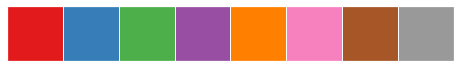

In [3]:
# color palatte for our methods
COLOR_PALETTE1 = sns.color_palette("Set1", 9, desat=1.)
COLOR_PALETTE = [COLOR_PALETTE1[k] for k in [0, 1, 2, 3, 4, 7, 6, 8]]
sns.palplot(COLOR_PALETTE)

#### Helper functions

In [4]:
# given a SEM, run all methods and return target risks and target test risks
def run_all_methods(sem1, methods, n=1000, repeats=10):
    M = sem1.M
    res_all = np.zeros((len(methods), repeats))
    res_all_test = np.zeros((len(methods), repeats))
    
    # generate data 
    for repeat in range(repeats):
        data = sem1.generateAllSamples(n)
        dataTest = sem1.generateAllSamples(n)
        # may use other target as well
        source = np.arange(M-1)
        target = M-1

        for i, m in enumerate(methods):
            me = m.fit(data, source=source, target=target)
            xtar, ytar = data[target]
            xtar_test, ytar_test = dataTest[target]
            targetE = util.MSE(me.ypred, ytar)
            targetNE = util.MSE(me.predict(xtar_test), ytar_test)
            res_all[i, repeat] = targetE
            res_all_test[i, repeat] = targetNE
    return res_all, res_all_test

# boxplot of the target risks of all methods in the method_index
def boxplot_all_methods(plt_handle, res_all, method_index, title='', names=[], ylim_option=0):   
    res_all_df = pd.DataFrame(res_all.T)
    res_all_df.columns = names
    res_all_df_melt = res_all_df.melt(var_name='methods', value_name='MSE')
    res_all_mean = np.mean(res_all, axis=1)
    
    plt_handle.set_title(title, fontsize=20)

    plt_handle.axhline(res_all_mean[1], ls='--', color='b')
    plt_handle.axhline(res_all_mean[0], ls='--', color='r')
    ax = sns.boxplot(x="methods", y="MSE", data=res_all_df_melt,
                     palette=[COLOR_PALETTE[i] for i in method_index],
                     ax=plt_handle)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-70, ha='left', fontsize=20)
    ax.tick_params(labelsize=20)
#     ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
    ax.yaxis.grid(False) # Hide the horizontal gridlines
    ax.xaxis.grid(True) # Show the vertical gridlines
#     ax.xaxis.set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("MSE", fontsize=20)

    if ylim_option == 1:
        lower_ylim = res_all_mean[0] -  (res_all_mean[1] - res_all_mean[0]) *0.3
        # upper_ylim = max(res_all_mean[1] + (res_all_mean[1] - res_all_mean[0]) *0.3, res_all_mean[0]*1.2)
        upper_ylim = res_all_mean[1] + (res_all_mean[1] - res_all_mean[0]) *0.3
        # get the boxes that are outside of the plot
        outside_index = np.where(res_all_mean >  upper_ylim)[0]
        for oindex in outside_index:
            ax.annotate("box\nbeyond\ny limit", xy=(oindex - 0.3, upper_ylim - (upper_ylim-lower_ylim)*0.15 ), fontsize=15)
        plt_handle.set_ylim(lower_ylim, upper_ylim)
    

def scatterplot_two_methods(plt_handle, res_all, index1, index2, names, colors, title="", ylimmax = 1.1):
    plt_handle.scatter(res_all[index1], res_all[index2], alpha=1.0, marker='+', c = np.array(colors).reshape(1, -1), s=100)
    plt_handle.set_xlabel(names[0], fontsize=20)
    plt_handle.set_ylabel(names[1], fontsize=20)
    plt_handle.tick_params(labelsize=20)
    
    if ylimmax <= 0:
        # set ylim automatically
#         ylimmax = np.max((np.max(res_all[index1]), np.max(res_all[index2])))
        ylimmax = np.percentile(np.concatenate((res_all[index1], res_all[index2])), 95)
        print("ylimmax automatically is set to %.3f" %ylimmax)
    # 
    plt_handle.plot([0, ylimmax],[0, ylimmax], 'k--', alpha=0.5)
    # plt.axis('equal')
    plt_handle.set_xlim(0.0, ylimmax)
    plt_handle.set_ylim(0.0, ylimmax)
    plt_handle.set_title(title, fontsize=20)

#### 1. Single source + anti-causal + no intervention on Y
Show tat DIP is better than OLSSrc.
> First, 3 boxplots: d = 3, 10, 20

> Second, 1 scatterplot comparing DIP and OLSSrc: fix d = 10, generate B 100 times

['Tar_Ridge0.0', 'SrcPool_Ridge0.0', 'DIPOracle_Match10.0_Ridge0.0', 'DIP_Match10.0_Ridge0.0']
['OLSTar', 'OLSSrc[1]', 'DIPOracle[1]', 'DIP[1]']


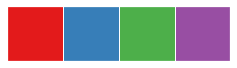

In [5]:
method_index = [0, 1, 2, 3]
names = [str(methods[i]) for i in method_index]
print(names)
names_short = ['OLSTar', "OLSSrc[1]", "DIPOracle[1]", "DIP[1]"]
print(names_short)
sns.palplot(np.array(COLOR_PALETTE)[method_index])
plt.show()

seed1 = int(123456 + np.exp(1) * 1000)

In [6]:
def simple_runboxplot_sem1(sem_nums, ds, names, method_index, fname, i2n_ratios=[1.], n=2000, repeats=10):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    for i, sem_num in enumerate(sem_nums): 
        for j, inter2noise_ratio_local in enumerate(i2n_ratios):
            print("Number of envs M=%d, inter2noise_ratio=%.1f" %(2, inter2noise_ratio_local))
            params = {'M': 2, 'inter2noise_ratio': inter2noise_ratio_local, 'd': ds[i]}

            sem1 = simudata.pick_sem(sem_num, 
                                     params=params, 
                                     seed=seed1)


            # run methods on data generated from sem
            res_all_sem1, res_all_test_sem1 = run_all_methods(sem1, [methods[i] for i in method_index], n=n, repeats=repeats)

            # plot
            boxplot_all_methods(axs[i], res_all_test_sem1, method_index, 
                                 title="linear SCM: d=%d" %(params['d']), names=names)

    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.6,
                        wspace=0.2)
    plt.savefig("paper_figures/sim/%s" %fname, bbox_inches="tight")
    plt.show()

Number of envs M=2, inter2noise_ratio=1.0
Number of envs M=2, inter2noise_ratio=1.0
Number of envs M=2, inter2noise_ratio=1.0


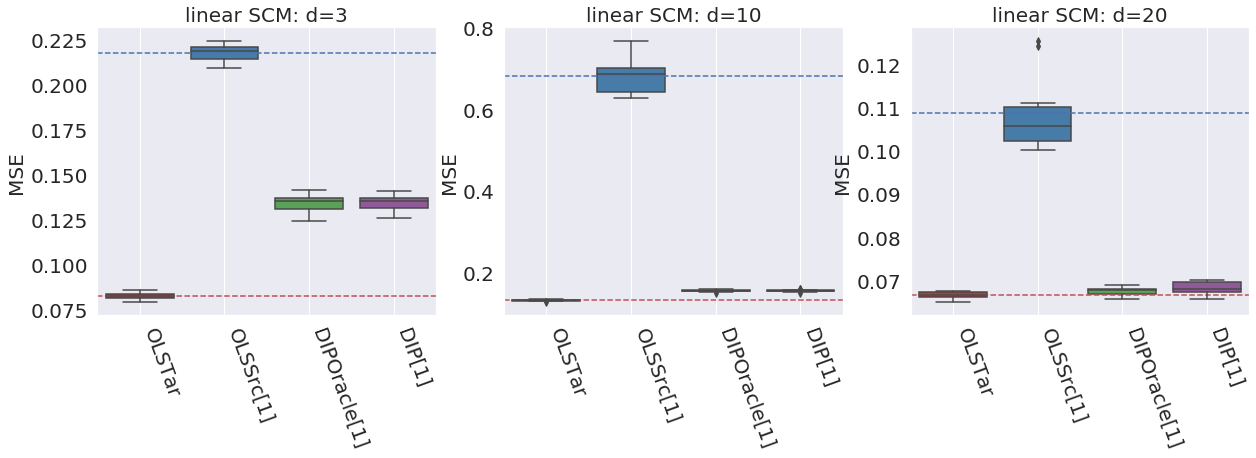

In [7]:
simple_runboxplot_sem1(sem_nums=['r0sm1d3x1', 'r0sm1d?x1', 'r0sm1d?x1'], ds=[3, 10, 20],
                       names=names_short,
                       method_index = method_index,
                       fname='sim_6_1_exp_1.pdf',
                       i2n_ratios=[1.],
                       n=5000, repeats=10)

In [8]:
# run code fo scatterplots
params = {'M': 2, 'inter2noise_ratio': 1.0, 'd': 10}
# number of times to generate SEM
semreps = 100
res_all = np.zeros((len(method_index), semreps))
for semrep in range(100):
    sem1 = simudata.pick_sem('r0sm1d?x1', 
                             params=params, 
                             seed=seed1+semrep)
    n = 5000
    repeats = 1
    # run methods on data generated from sem
    res_all_sem1, res_all_test_sem1 = run_all_methods(sem1, [methods[i] for i in method_index], n=n, repeats=repeats)
    res_all[:, semrep] =  np.mean(res_all_test_sem1, axis=1)
    

ylimmax automatically is set to 0.566


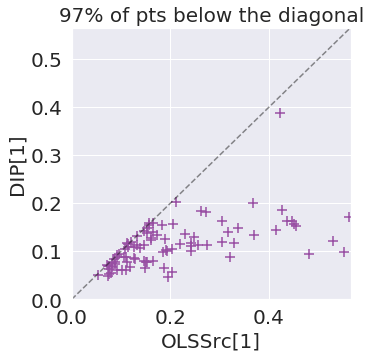

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))

index1 = 1
index2 = 3

nb_below_diag = np.sum(res_all[index1] >= res_all[index2])
scatterplot_two_methods(axs, res_all, index1, index2, [names_short[index1], names_short[index2]], COLOR_PALETTE[method_index[index2]],
                        title="%d%% of pts below the diagonal" %nb_below_diag, ylimmax = -1)

plt.savefig("paper_figures/sim/%s" %'sim_6_1_exp_1_scatter.pdf', bbox_inches="tight")

plt.show()



#### 2. Multiple source + anti-causal + without intervention on Y 
Show DIPweigh is better than DIP
> First, 3 boxplots d = 3, 10, 20, vary number of envs M up tp 9

> Second, 1 scatterplot comparing DIPweigh and DIP: fix d = 10, generate B 100 times 


['Tar_Ridge0.0', 'DIP_Match10.0_Ridge0.0', 'DIPweigh_Match10.0_Ridge0.0']
['OLSTar', 'DIP[1]', 'DIPweigh']


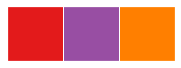

In [10]:
method_index = [0, 3, 4]
names = [str(methods[i]) for i in method_index]
print(names)
names_short = ['OLSTar', "DIP[1]", "DIPweigh"]
print(names_short)

sns.palplot(np.array(COLOR_PALETTE)[method_index])
plt.show()

In [11]:
# need to run methods with varying Ms
def run_all_methods_incM(sem1, methods, Ms, n=1000, repeats=10):
    M = sem1.M
    res_all = np.zeros((len(Ms), len(names), repeats))
    res_all_test = np.zeros((len(Ms), len(names), repeats))
    
    # generate data 
    for repeat in range(repeats):
        data = sem1.generateAllSamples(n)
        dataTest = sem1.generateAllSamples(n)
        
        
        for j, M_local in enumerate(Ms):
            # increasing number of sources
            source = np.arange(M_local-1)
            # fixed target env
            target = M - 1

            for i, m in enumerate(methods):
                me = m.fit(data, source=source, target=target)
                xtar, ytar = data[target]
                xtar_test, ytar_test = dataTest[target]
                targetE = util.MSE(me.ypred, ytar)
                targetNE = util.MSE(me.predict(xtar_test), ytar_test)
                res_all[j, i, repeat] = targetE
                res_all_test[j, i, repeat] = targetNE
    #         print("Target %-30s error=%.3f errorTest=%.3f" %(names[i], targetE, targetNE))
    return res_all, res_all_test

In [12]:
def simple_runboxplot_sem2(sem_nums, ds, names, method_index, fname, Ms, i2n_ratio=1.0, n=2000, repeats=10):
    fig, axs = plt.subplots(1, 3, figsize=(20,5))
    for i, sem_num in enumerate(sem_nums): 
        
        
        params = {'M': np.max(Ms)+2, 'inter2noise_ratio': i2n_ratio, 'd': ds[i]}

        sem1 = simudata.pick_sem(sem_num, 
                                 params=params, 
                                 seed=seed1+int(np.exp(1)*1000))


        # run methods on data generated from sem
        res_all_sem1, res_all_test_sem1 = run_all_methods_incM(sem1, [methods[i] for i in method_index], Ms, n=n, repeats=repeats)
        
        
        res_all_sem1_comb = np.zeros((res_all_test_sem1.shape[1]+len(Ms)-1, res_all_test_sem1.shape[2]))
        res_all_sem1_comb[:res_all_test_sem1.shape[1], :] = res_all_test_sem1[0, :]
        method_index_comb = method_index[:-1].copy()
        names_comb = names[:-1].copy()
        for j, M_local in enumerate(Ms):
            res_all_sem1_comb[res_all_test_sem1.shape[1]-1+j, :] = res_all_test_sem1[j, -1, :]
            method_index_comb.append(method_index[-1])
            names_comb.append(names[-1]+"(M=%d)" %(M_local-1))
        # plot
        boxplot_all_methods(axs[i], res_all_sem1_comb, method_index_comb, 
                             title="linear SCM: d=%d, Mmax=%d" %(params['d'], M_local-1),
                             names=names_comb)

    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.6,
                        wspace=0.2)
    plt.savefig("paper_figures/sim/%s" %fname, bbox_inches="tight")
    plt.show()

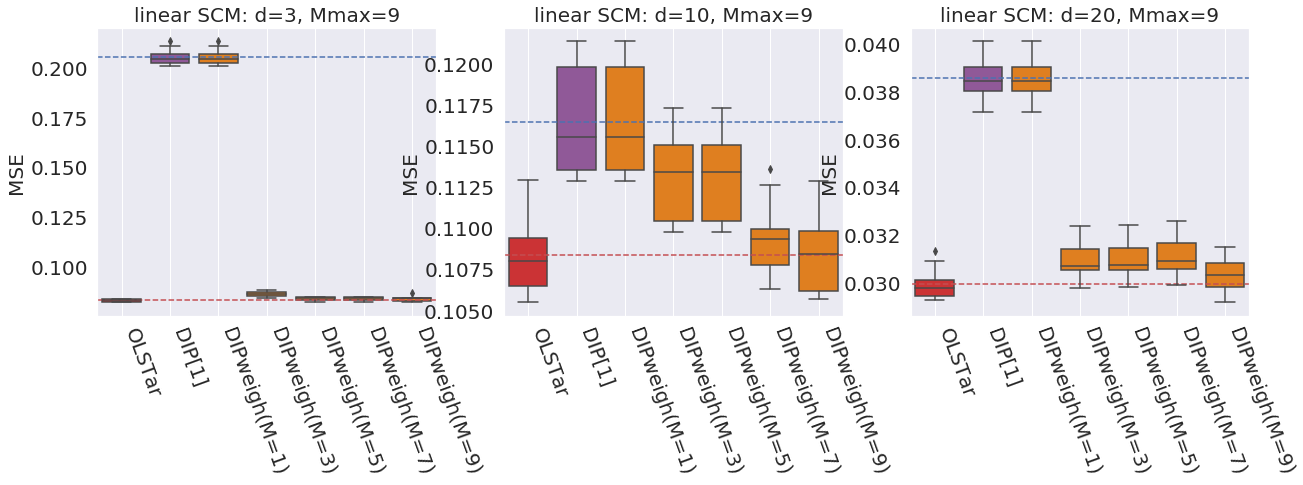

In [13]:
simple_runboxplot_sem2(sem_nums=['r0sm1d3x1', 'r0sm1d?x1', 'r0sm1d?x1'], ds=[3, 10, 20],
                     names=names_short,
                    method_index = method_index,
                   fname='sim_6_1_exp_2.pdf',
                   Ms = [2, 4, 6, 8, 10],
                   i2n_ratio=5.0,
                   n=5000, repeats=10)

In [14]:
params = {'M': 8, 'inter2noise_ratio': 1.0, 'd': 10}
# number of times to generate SEM
semreps = 100
res_all = np.zeros((len(method_index), semreps))
for semrep in range(100):
    sem1 = simudata.pick_sem('r0sm1d?x1', 
                             params=params, 
                             seed=seed1+int(np.exp(2)*1000)+semrep)
    n = 5000
    repeats = 1
    # run methods on data generated from sem
    res_all_sem1, res_all_test_sem1 = run_all_methods(sem1, [methods[i] for i in method_index], n=n, repeats=repeats)
    res_all[:, semrep] =  np.mean(res_all_test_sem1, axis=1)



ylimmax automatically is set to 0.213


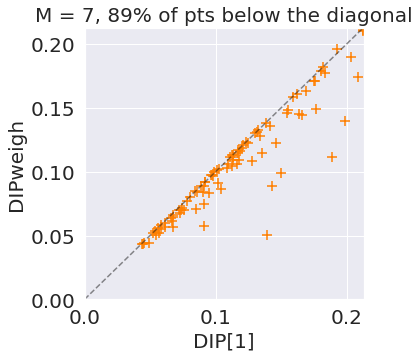

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))

nb_below_diag = np.sum(res_all[1] >= res_all[2])
scatterplot_two_methods(axs, res_all, 1, 2, [names_short[1], names_short[2]], COLOR_PALETTE[method_index[2]], 
                        title="M = %d, %d%% of pts below the diagonal" % (params['M']-1, nb_below_diag), ylimmax = -1)

plt.savefig("paper_figures/sim/%s" %'sim_6_1_exp_2_scatter.pdf', bbox_inches="tight")

plt.show()



#### 3. Multiple source + anti-causal + with intervention on Y with CICs: 
Show CIRM and CIRMweigh works better than DIP
> First, 1 boxplot d = 20, M = 14

> Second, 3 scatterplots comparing CIP vs. DIPweigh, CIRMweigh vs. SrcPool, CIRMweigh vs. DIPweigh


['Tar_Ridge0.0', 'SrcPool_Ridge0.0', 'DIPweigh_Match10.0_Ridge0.0', 'CIP_CIP1.0_Ridge0.0', 'CIRMweigh_CIP1.0_Match10.0_Ridge0.0']
['OLSTar', 'SrcPool', 'DIPweigh', 'CIP', 'CIRMweigh']


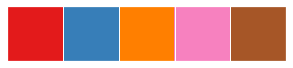

In [16]:
method_index = [0, 1, 4, 5, 6]
names = [str(methods[i]) for i in method_index]
print(names)
names_short = ['OLSTar', "SrcPool", "DIPweigh", "CIP", "CIRMweigh"]
print(names_short)

sns.palplot(np.array(COLOR_PALETTE)[method_index])
plt.show()

In [17]:
def simple_runboxplot_sem3(sem_nums, ds, names, method_index, fname, cicnums=[1, 7, 10], Ms=[3, 9, 27], i2n_ratios=[1.], n=2000, repeats=10):
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    for i, sem_num in enumerate(sem_nums): 
        for j, M_local in enumerate(Ms):
            inter2noise_ratio = i2n_ratios[0]
            print("Number of envs M=%d, inter2noise_ratio=%.1f" %(M_local, inter2noise_ratio))
            params = {'M': M_local, 'inter2noise_ratio': inter2noise_ratio, 'd': ds[i], 'cicnum': cicnums[i],'interY': 1.0}

            sem1 = simudata.pick_sem(sem_num, 
                                     params=params, 
                                     seed=seed1 + int(np.exp(3) * 1000))
            
            print(params)


            # run methods on data generated from sem
            res_all_sem1, res_all_test_sem1 = run_all_methods(sem1, [methods[i] for i in method_index],
                                                              n=n, repeats=repeats)

            # plot
            boxplot_all_methods(axs, res_all_test_sem1, method_index, 
                                 title="linear SCM: d=%d, M=%d" %(params['d'], params['M']-1),
                                 names=names, ylim_option=1)

    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.6,
                        wspace=0.2)
    plt.savefig("paper_figures/sim/%s" %fname, bbox_inches="tight")
    plt.show()

Number of envs M=15, inter2noise_ratio=1.0
{'M': 15, 'inter2noise_ratio': 1.0, 'd': 20, 'cicnum': 10, 'interY': 1.0}


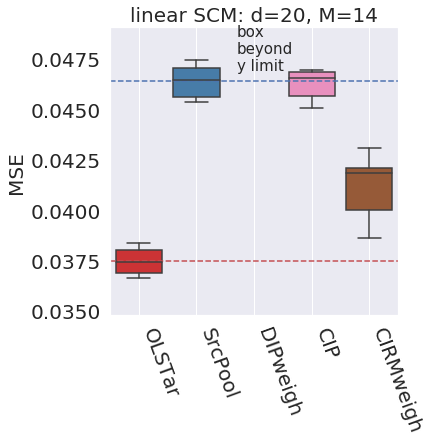

In [18]:
simple_runboxplot_sem3(sem_nums=['r0sm1d?x4'], ds=[20],
                       names=names_short,
                       method_index = method_index,
                       fname='sim_6_1_exp_3_d20M15.pdf',
                       cicnums=[10],
                       Ms = [15],
                       i2n_ratios=[1.],
                       n=5000, repeats=10)

In [19]:
params = {'M': 15, 'inter2noise_ratio': 1., 'd': 20, 'cicnum': 10,'interY': 1.}

# number of times to generate SEM
semreps = 100
res_all = np.zeros((len(method_index), semreps))
for semrep in range(semreps):
    sem1 = simudata.pick_sem('r0sm1d?x4', 
                             params=params, 
                             seed=seed1 + int(np.exp(3) * 1000) +semrep)
    n = 5000
    repeats = 1
    # run methods on data generated from sem
    res_all_sem1, res_all_test_sem1 = run_all_methods(sem1, [methods[i] for i in method_index], n=n, repeats=repeats)
    res_all[:, semrep] =  np.mean(res_all_test_sem1, axis=1)
    


ylimmax automatically is set to 3.392
ylimmax automatically is set to 0.131
ylimmax automatically is set to 3.392


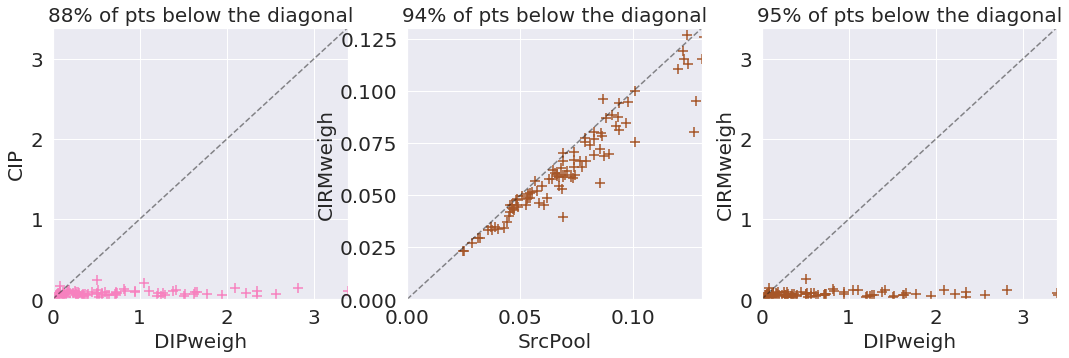

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))
for i, (index1, index2) in enumerate([(2, 3), (1, 4), (2, 4)]):
    nb_below_diag = np.sum(res_all[index1] >= res_all[index2])
    scatterplot_two_methods(axs[i], res_all, index1, index2, [names_short[index1], names_short[index2]],
                            COLOR_PALETTE[method_index[index2]],
                        title="%d%% of pts below the diagonal" %nb_below_diag, ylimmax = -1)
plt.savefig("paper_figures/sim/%s" %"sim_6_1_exp_3_scatter_all3.pdf", bbox_inches="tight")
plt.show()

#### 4. Single source + *causal* + without intervention on Y
Show that in the causal DA problem, DIP fails
> First, 3 boxplots d = 3, 10, 20

> Second, 1 scatterplot comparing DIP with OLSSrc: fix d = 10, generate B 100 times

['Tar_Ridge0.0', 'SrcPool_Ridge0.0', 'DIPOracle_Match10.0_Ridge0.0', 'DIP_Match10.0_Ridge0.0']
['OLSTar', 'OLSSrc[1]', 'DIPOracle[1]', 'DIP[1]']


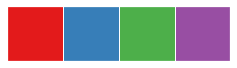

In [21]:
method_index = [0, 1, 2, 3]
names = [str(methods[i]) for i in method_index]
print(names)
names_short = ['OLSTar', "OLSSrc[1]", "DIPOracle[1]", "DIP[1]"]
print(names_short)


sns.palplot(np.array(COLOR_PALETTE)[method_index])
plt.show()


Number of envs M=2, inter2noise_ratio=1.0
Number of envs M=2, inter2noise_ratio=1.0
Number of envs M=2, inter2noise_ratio=1.0


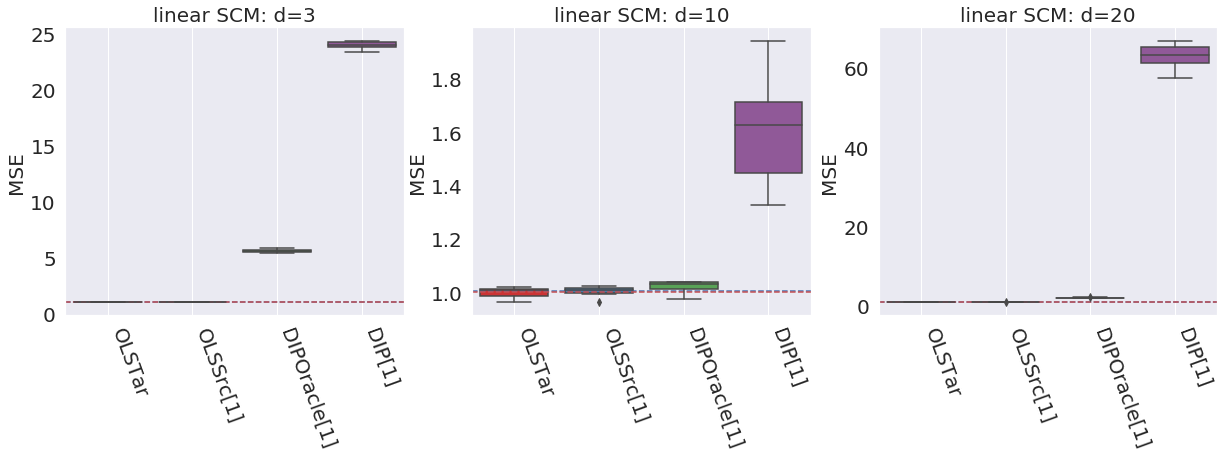

In [22]:
simple_runboxplot_sem1(sem_nums=['r1sm1d3x1', 'r1sm1d?x1', 'r1sm1d?x1'], ds=[3, 10, 20],
                       names=names_short,
                       method_index = method_index,
                       fname='sim_6_1_exp_4.pdf',i2n_ratios=[1.0],
                       n=5000, repeats=10)

In [23]:

 
params = {'M': 2, 'inter2noise_ratio': 1.0, 'd': 10}
# number of times to generate SEM
semreps = 100
res_all = np.zeros((len(method_index), semreps))
for semrep in range(100):
    sem1 = simudata.pick_sem('r1sm1d?x1', 
                             params=params, 
                             seed=seed1+semrep)
    n = 5000
    repeats = 1
    # run methods on data generated from sem
    res_all_sem1, res_all_test_sem1 = run_all_methods(sem1, [methods[i] for i in method_index], n=n, repeats=repeats)
    res_all[:, semrep] =  np.mean(res_all_test_sem1, axis=1)


ylimmax automatically is set to 207.137


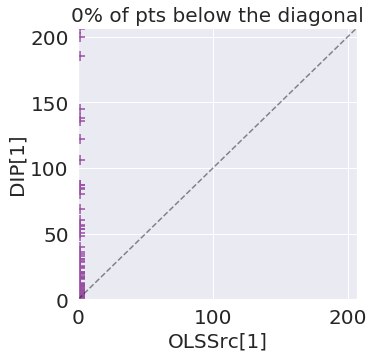

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))

nb_below_diag = np.sum(res_all[1] >= res_all[3])
scatterplot_two_methods(axs, res_all, 1, 3, [names_short[1], names_short[3]], 
                        COLOR_PALETTE[method_index[3]],
                        title="%d%% of pts below the diagonal" %nb_below_diag, ylimmax = -1)

plt.savefig("paper_figures/sim/%s" %'sim_6_1_exp_4_scatter.pdf', bbox_inches="tight")

plt.show()



#### 5. Single source + *mixed*  + without intervention on Y
Show that in mixed DA problem, DIP fails but DIP<> after removing the causal part works
> First, 2 boxplots d = 10, 20

> Second, 2 scatterplots comparing DIP vs. OLSSrc, DIP<> vs. OLSSrc

['Tar_Ridge0.0', 'SrcPool_Ridge0.0', 'DIPOracle_Match10.0_Ridge0.0', 'DIP_Match10.0_Ridge0.0']
['OLSTar', 'OLSSrc[1]', 'DIPOracle[1]', 'DIP[1]', 'DIP<>[1]']


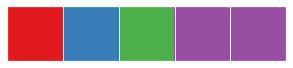

In [25]:
method_index = [0, 1, 2, 3]
names = [str(methods[i]) for i in method_index]
print(names)
names_short = ['OLSTar', "OLSSrc[1]", "DIPOracle[1]", "DIP[1]", "DIP<>[1]"]
print(names_short)

method_index_add = method_index + [3]
sns.palplot(np.array(COLOR_PALETTE)[method_index_add])
plt.show()


In [26]:
def simple_runboxplot_sem5(sem_nums, ds, names, method_index, fname, i2n_ratios=[1.], n=2000, repeats=10):
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    for i, sem_num in enumerate(sem_nums): 
        for j, inter2noise_ratio_local in enumerate(i2n_ratios):
            print("Number of envs M=%d, inter2noise_ratio=%.1f" %(2, inter2noise_ratio_local))
            params = {'M': 2, 'inter2noise_ratio': inter2noise_ratio_local, 'd': ds[i]}

            sem1 = simudata.pick_sem(sem_num, 
                                     params=params, 
                                     seed=seed1 + int(np.exp(5)*1000))


            causal_index = np.where(sem1.B[:-1, -1] == 0)[0]
            dipmix = semiclass.DIPmix(causal_index=causal_index, lamMatch=lamMatch, lamL2=lamL2, sourceInd=0)
            # run methods on data generated from sem
            res_all_sem1, res_all_test_sem1 = run_all_methods(sem1, [methods[i] for i in method_index] + [dipmix], n=n, repeats=repeats)

            # plot
            boxplot_all_methods(axs[i], res_all_test_sem1, method_index_add, 
                                 title="linear SCM: d=%d" %(params['d']), names=names, ylim_option=1)

    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.6,
                        wspace=0.2)
    plt.savefig("paper_figures/sim/%s" %fname, bbox_inches="tight")
    plt.show()

Number of envs M=2, inter2noise_ratio=1.0
Number of envs M=2, inter2noise_ratio=1.0


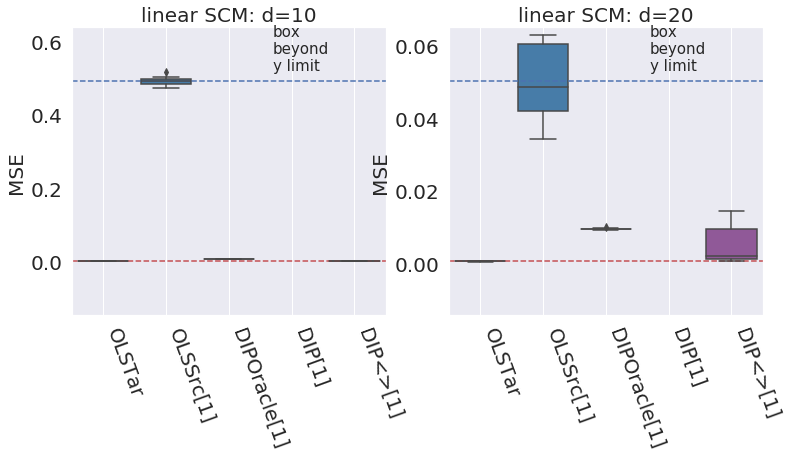

In [27]:
simple_runboxplot_sem5(sem_nums=['r2sm1d?x1', 'r2sm1d?x1'], ds=[10, 20],
                       names=names_short,
                       method_index = method_index,
                       fname='sim_6_1_exp_5.pdf',
                       i2n_ratios=[1.],
                       n=5000, repeats=10)

In [28]:

params = {'M': 2, 'inter2noise_ratio': 1.0, 'd': 10}
# number of times to generate SEM
semreps = 100
res_all = np.zeros((len(method_index_add), semreps))
for semrep in range(100):
    sem1 = simudata.pick_sem('r2sm1d?x1', 
                             params=params, 
                             seed=seed1+semrep)
    n = 5000
    repeats = 1
    # run methods on data generated from sem
    causal_index = np.where(sem1.B[:-1, -1] == 0)[0]
    dipmix = semiclass.DIPmix(causal_index=causal_index, lamMatch=lamMatch, lamL2=lamL2, sourceInd=0)
    res_all_sem1, res_all_test_sem1 = run_all_methods(sem1, [methods[i] for i in method_index] + [dipmix], n=n, repeats=repeats)
    res_all[:, semrep] =  np.mean(res_all_test_sem1, axis=1)
    

ylimmax automatically is set to 44.565


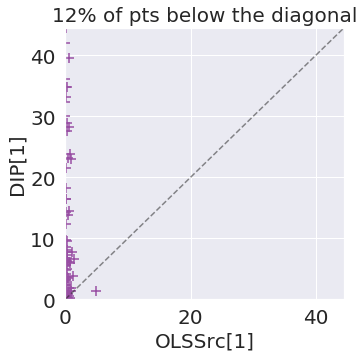

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))

index1 = 1
index2 = 3

nb_below_diag = np.sum(res_all[index1] >= res_all[index2])
scatterplot_two_methods(axs, res_all, index1, index2, [names_short[index1], names_short[index2]],
                        COLOR_PALETTE[method_index[index2]],
                        title="%d%% of pts below the diagonal" %nb_below_diag, ylimmax = -1)

plt.savefig("paper_figures/sim/%s" %'sim_6_1_exp_5_scatter.pdf', bbox_inches="tight")

plt.show()



ylimmax automatically is set to 0.688


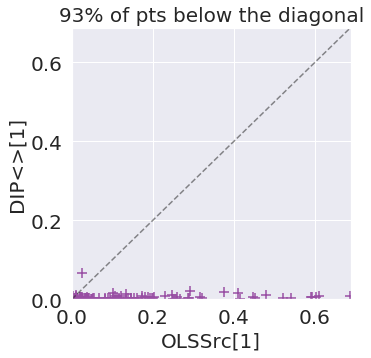

In [30]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))

index1 = 1
index2 = 4

nb_below_diag = np.sum(res_all[index1] >= res_all[index2])
scatterplot_two_methods(axs, res_all, index1, index2, [names_short[index1], names_short[index2]],
                        COLOR_PALETTE[method_index_add[index2]],
                        title="%d%% of pts below the diagonal" %nb_below_diag, ylimmax = -1)

plt.savefig("paper_figures/sim/%s" %'sim_6_1_exp_5_scatter_mix.pdf', bbox_inches="tight")

plt.show()



#### 6. Multiple source + anti-causal + with intervention on Y + without CICs
Show that CIP and CIRM can have large target risk if CICs are not enforced
> 2 scatterplots comparing CIP vs. SrcPool, CIP vs. DIPweigh

> 2 scatterplots comparing CIRMweigh vs. SrcPool, CIRMweigh vs. DIPweigh


['Tar_Ridge0.0', 'SrcPool_Ridge0.0', 'DIPweigh_Match10.0_Ridge0.0', 'CIP_CIP1.0_Ridge0.0', 'CIRMweigh_CIP1.0_Match10.0_Ridge0.0']
['OLSTar', 'SrcPool', 'DIPweigh', 'CIP', 'CIRMweigh']


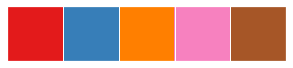

In [31]:
method_index = [0, 1, 4, 5, 6]
names = [str(methods[i]) for i in method_index]
print(names)
names_short = ['OLSTar', "SrcPool", "DIPweigh", "CIP", "CIRMweigh"]
print(names_short)

sns.palplot(np.array(COLOR_PALETTE)[method_index])
plt.show()


Number of envs M=3, inter2noise_ratio=1.0
{'M': 3, 'inter2noise_ratio': 1.0, 'd': 20, 'cicnum': 0, 'interY': 1.0}
Number of envs M=9, inter2noise_ratio=1.0
{'M': 9, 'inter2noise_ratio': 1.0, 'd': 20, 'cicnum': 0, 'interY': 1.0}
Number of envs M=27, inter2noise_ratio=1.0
{'M': 27, 'inter2noise_ratio': 1.0, 'd': 20, 'cicnum': 0, 'interY': 1.0}


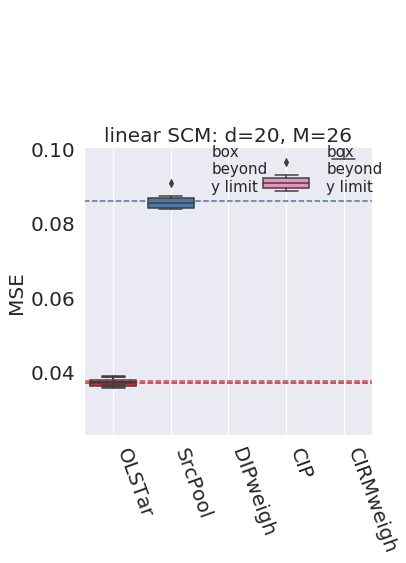

In [32]:
simple_runboxplot_sem3(sem_nums=['r0sm1d?x3'], ds=[20],
                       names=names_short,
                       method_index = method_index,
                       fname='sim_6_1_exp_6.pdf',
                       cicnums=[0],
                       Ms = [3, 9, 27],
                       i2n_ratios=[1.],
                       n=5000, repeats=10)

In [33]:
params = {'M': 20, 'inter2noise_ratio': 1.0, 'd': 20, 'cicnum': 0,'interY': 1.}

# number of times to generate SEM
semreps = 100
res_all = np.zeros((len(method_index), semreps))
for semrep in range(semreps):
    sem1 = simudata.pick_sem('r0sm1d?x3', 
                             params=params, 
                             seed=seed1+int(np.exp(6)*1000)+semrep)
    n = 5000
    repeats = 1
    # run methods on data generated from sem
    res_all_sem1, res_all_test_sem1 = run_all_methods(sem1, [methods[i] for i in method_index], n=n, repeats=repeats)
    res_all[:, semrep] =  np.mean(res_all_test_sem1, axis=1)

ylimmax automatically is set to 0.387
ylimmax automatically is set to 3.069
ylimmax automatically is set to 0.387
ylimmax automatically is set to 3.069


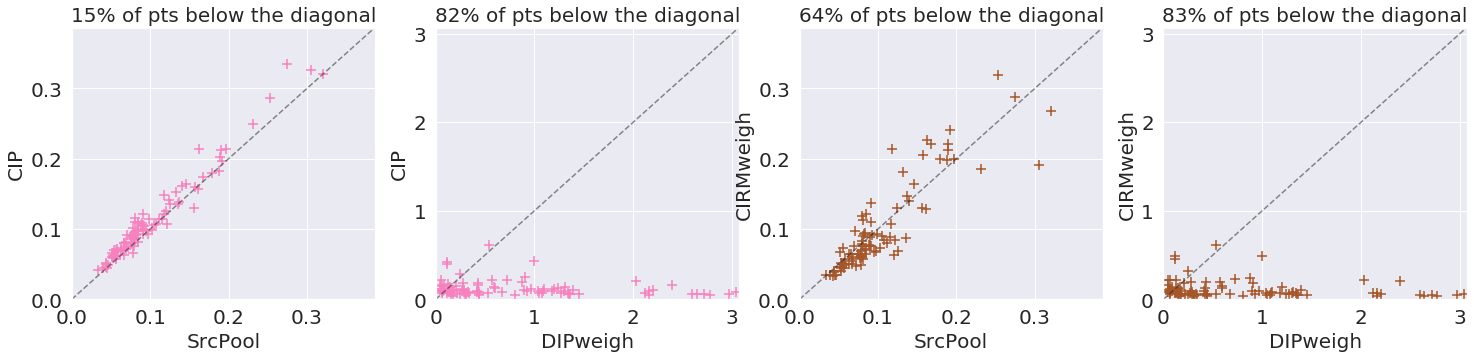

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(25,5))
for i, (index1, index2) in enumerate([(1, 3), (2, 3), (1, 4), (2, 4)]):
    nb_below_diag = np.sum(res_all[index1] >= res_all[index2])
    scatterplot_two_methods(axs[i], res_all, index1, index2, [names_short[index1], names_short[index2]],
                            COLOR_PALETTE[method_index[index2]],
                        title="%d%% of pts below the diagonal" %nb_below_diag, ylimmax = -1)
plt.savefig("paper_figures/sim/%s" %"sim_6_1_exp_6_scatter_all4.pdf", bbox_inches="tight")
plt.show()

#### 7. Multiple source +  *mixed*  + with intervention on Y + with CICs
Show that the original CIRM does not work in mixed DA, CIRM<> works
> 1 scatterplot comparing CIRMweigh vs. SrcPool

> 3 scatterplots comparing CIRM<>weigh vs. SrcPool, CIRM<>weigh vs. DIPweigh, CIRM<>weigh vs. CIRMweigh

['OLSTar', 'SrcPool', 'DIPweigh', 'CIP', 'CIRMweigh', 'CIRM<>weigh']


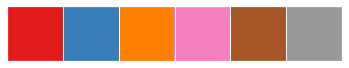

In [35]:
method_index = [0, 1, 4, 5, 6]

names_short = ['OLSTar', "SrcPool", "DIPweigh", "CIP", "CIRMweigh", "CIRM<>weigh"]
print(names_short)

method_index_add = method_index + [7]
sns.palplot(np.array(COLOR_PALETTE)[method_index_add])
plt.show()


In [36]:
params = {'M': 15, 'inter2noise_ratio': 1., 'd': 20, 'cicnum': 10,'interY': 1.}

# number of times to generate SEM
semreps = 100
res_all = np.zeros((len(method_index) + 1, semreps))
for semrep in range(semreps):
    sem1 = simudata.pick_sem('r2sm1d?x4', 
                             params=params, 
                             seed=seed1+int(np.exp(7)*1000)+semrep)
    n = 5000
    repeats = 1
    causal_index = np.where(sem1.B[:-1, -1] == 0)[0]
    cirmmix = semiclass.CIRMmixweigh(causal_index=causal_index, lamCIP=lamCIP, lamMatch=lamMatch, lamL2=lamL2)
    # run methods on data generated from sem
    res_all_sem1, res_all_test_sem1 = run_all_methods(sem1, [methods[i] for i in method_index] + [cirmmix], n=n, repeats=repeats)
    res_all[:, semrep] =  np.mean(res_all_test_sem1, axis=1)


ylimmax automatically is set to 0.407
ylimmax automatically is set to 0.254
ylimmax automatically is set to 1.552
ylimmax automatically is set to 0.238


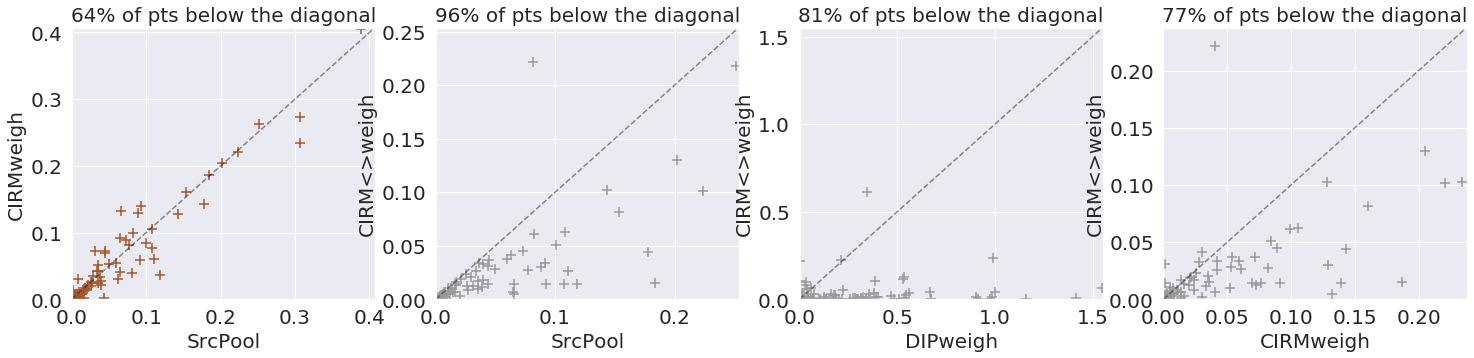

In [37]:
fig, axs = plt.subplots(1, 4, figsize=(25,5))
for i, (index1, index2) in enumerate([(1, 4), (1, 5), (2, 5), (4, 5)]):
    nb_below_diag = np.sum(res_all[index1] >= res_all[index2])
    scatterplot_two_methods(axs[i], res_all, index1, index2, [names_short[index1], names_short[index2]],
                            COLOR_PALETTE[method_index_add[index2]],
                        title="%d%% of pts below the diagonal" %nb_below_diag, ylimmax = -1)
plt.savefig("paper_figures/sim/%s" %"sim_6_1_exp_7_scatter_all4.pdf", bbox_inches="tight")
plt.show()